# Initialization
---
- example data (Heidi 2003 data, 1 day Synechococcus)

In [1]:
#setwd("/Users/ribalet/Documents/DATA/Codes/ssPopModel")
setwd("/Users/francois/Documents/DATA/Codes/ssPopModel")


library(R.matlab)
library(seewave) # Kullback-Leibler 
library(DEoptim)
library(cmaes) 

df <- readMat("inst/sosik2003/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("inst/sosik2003/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

resol <- 10
dt <- resol/60
time.interval <- median(diff(as.numeric(colnames(V.hists))))
ti <- as.numeric(colnames(V.hists))

# create Light data with 'dt' time interval.
seq <- NULL
    for(i in 1:(length(ti)-1)){
		s <- seq(ti[i], ti[i+1], length.out=1/dt)
		seq <- c(seq, s)
		}
ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
Einterp <- ep$y
Einterp[Einterp < 0] <- 0

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Warning message:
"package 'seewave' was built under R version 3.5.2"Loading required package: parallel

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich



- Load matrix model

In [2]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
        resp <-  rep(0, length(y)) # proportion of carbon storage to total carbon

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
    	stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- $Sigma$ function for sum of squared residuals


In [3]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
        
                gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance

In [4]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
            
                 gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T) * 10
			return(sigma)

}


- $Sigma$ function for Huber loss

In [5]:
###############
## sigma.hl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# using Hubert Loss (1954) approach.

	.sigma.hl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
           
                gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

        delta <- 1.345
			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
                    # Huber loss calculation
                    a <- N.dist[, hr+1] - round(TotN[hr+1]*wt.norm,1)
                    loss <- ifelse(abs(a) <= delta,
                                       0.5 * a^2,
                                       delta * (abs(a) - 0.5 * delta))
                    sigma[,hr] <- mean(loss)
                    }
            sigma <- sum(sigma)/100 ## HUBER loss

			return(sigma)

}

# 1. Objective functions
---

- ### sum of squared residuals 
$$
Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2

In [6]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) / 10
        b <- as.numeric(params[3]) * 10
        E_star <- as.numeric(params[4]) * 1000
		resnorm <- opt$optim$bestval


Iteration: 10 bestvalit: 5.075617 bestmemit:    0.179663    0.396302    0.404837    0.295469
Iteration: 20 bestvalit: 4.978458 bestmemit:    0.165957    0.360216    0.405939    0.253745
Iteration: 30 bestvalit: 4.978458 bestmemit:    0.165957    0.360216    0.405939    0.253745
Iteration: 40 bestvalit: 4.976822 bestmemit:    0.166804    0.368676    0.406975    0.249949
Iteration: 50 bestvalit: 4.976229 bestmemit:    0.166611    0.363904    0.405678    0.254598
Iteration: 60 bestvalit: 4.975278 bestmemit:    0.164483    0.362703    0.406415    0.255661
Iteration: 70 bestvalit: 4.975278 bestmemit:    0.164483    0.362703    0.406415    0.255661
Iteration: 80 bestvalit: 4.975176 bestmemit:    0.166312    0.362094    0.405573    0.255323
Iteration: 90 bestvalit: 4.974808 bestmemit:    0.165915    0.359256    0.404294    0.256814
Iteration: 100 bestvalit: 4.974219 bestmemit:    0.165893    0.358651    0.404204    0.256407
Iteration: 110 bestvalit: 4.973366 bestmemit:    0.166220    0.361945

- ### Kullback-Leibler divergence
$$
Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [7]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax. <- as.numeric(params[1]) 
        dmax. <- as.numeric(params[2]) / 10
        b. <- as.numeric(params[3]) * 10
        E_star. <- as.numeric(params[4]) * 1000
		resnorm. <- opt$optim$bestval


Iteration: 10 bestvalit: 2.332285 bestmemit:    0.170511    0.297160    0.402037    0.242986
Iteration: 20 bestvalit: 2.324781 bestmemit:    0.188289    0.329084    0.373517    0.258943
Iteration: 30 bestvalit: 2.313632 bestmemit:    0.178130    0.353839    0.387053    0.262867
Iteration: 40 bestvalit: 2.301956 bestmemit:    0.170126    0.321049    0.392715    0.256747
Iteration: 50 bestvalit: 2.301220 bestmemit:    0.169772    0.322119    0.386374    0.256068
Iteration: 60 bestvalit: 2.297441 bestmemit:    0.171580    0.319096    0.389579    0.261268
Iteration: 70 bestvalit: 2.297441 bestmemit:    0.171580    0.319096    0.389579    0.261268
Iteration: 80 bestvalit: 2.297441 bestmemit:    0.171580    0.319096    0.389579    0.261268
Iteration: 90 bestvalit: 2.297441 bestmemit:    0.171580    0.319096    0.389579    0.261268
Iteration: 100 bestvalit: 2.297441 bestmemit:    0.171580    0.319096    0.389579    0.261268
Iteration: 110 bestvalit: 2.297441 bestmemit:    0.171580    0.319096

- ### Huber loss 
$$
L =\begin{cases}
\frac12(y - \hat{y})^2 & for |y - \hat{y}| \leq d\\
d|y - \hat{y}| - \frac12 d^2 & otherwise
\end{cases}
$$


In [8]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax.. <- as.numeric(params[1]) 
        dmax.. <- as.numeric(params[2]) / 10
        b.. <- as.numeric(params[3]) * 10
        E_star.. <- as.numeric(params[4]) * 1000
		resnorm.. <- opt$optim$bestval

Iteration: 10 bestvalit: 6.769443 bestmemit:    0.144643    0.325206    0.409400    0.236379
Iteration: 20 bestvalit: 6.735989 bestmemit:    0.174777    0.355599    0.402634    0.217740
Iteration: 30 bestvalit: 6.734877 bestmemit:    0.181877    0.374815    0.390279    0.267686
Iteration: 40 bestvalit: 6.718096 bestmemit:    0.171569    0.345834    0.395447    0.246731
Iteration: 50 bestvalit: 6.716137 bestmemit:    0.171545    0.345687    0.387464    0.252465
Iteration: 60 bestvalit: 6.715730 bestmemit:    0.171162    0.344524    0.386580    0.256306
Iteration: 70 bestvalit: 6.715697 bestmemit:    0.171252    0.343827    0.388195    0.256301
Iteration: 80 bestvalit: 6.715534 bestmemit:    0.172122    0.351472    0.392118    0.249073
Iteration: 90 bestvalit: 6.715534 bestmemit:    0.172122    0.351472    0.392118    0.249073
Iteration: 100 bestvalit: 6.715534 bestmemit:    0.172122    0.351472    0.392118    0.249073
Iteration: 110 bestvalit: 6.715534 bestmemit:    0.172122    0.351472

##  Results

In [9]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- Vproj.. <-V.hists
Nproj <- Nproj. <- Nproj.. <- N.dist
mu_N <- mu_N. <- mu_N.. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
          		    
      B.. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
      Nproj..[,hr+1] <- round(B.. %*% Nproj..[,hr]) # calculate numbers of individuals
      Vproj..[,hr+1] <- B.. %*% Vproj..[,hr] # calculate the projected size-frequency distribution
	    Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
		mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
					    ((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)
Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2),"-",round(d.mu_N..,2)))

[1] "daily growth rate= 0.73 - 0.72 - 0.76"


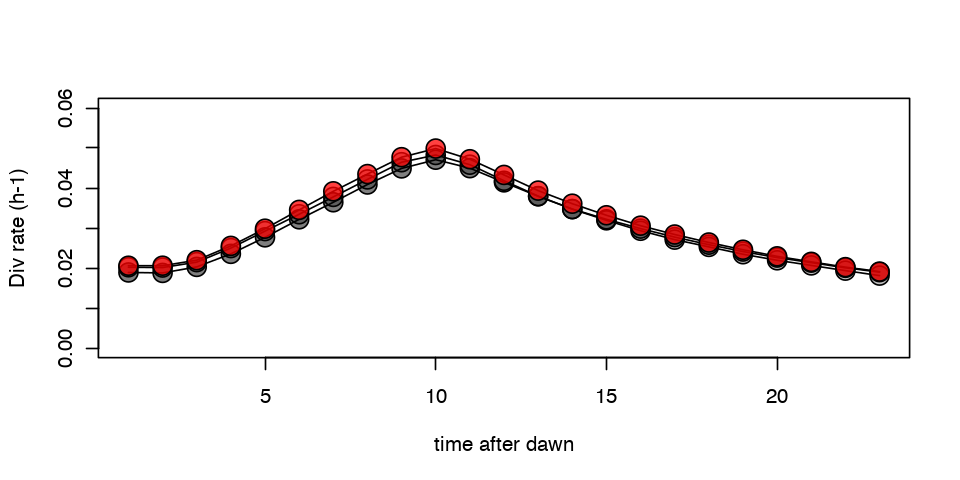

In [10]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
    points(mu_N..[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.75))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

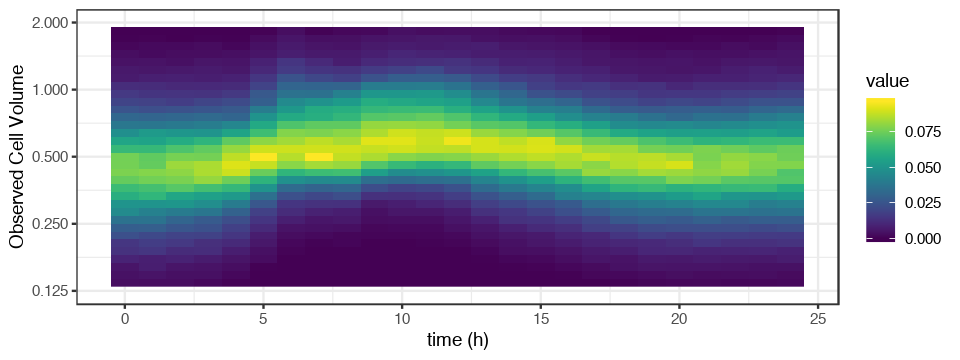

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

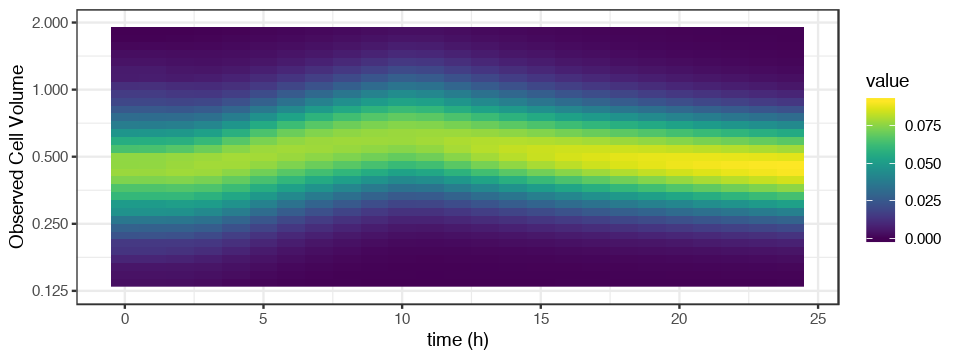

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

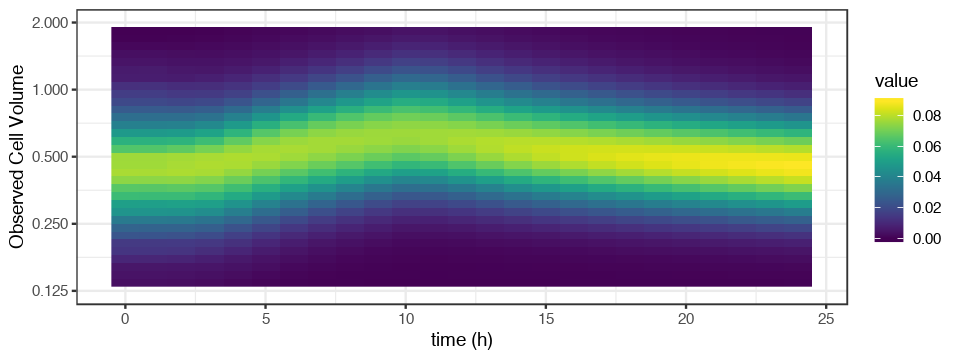

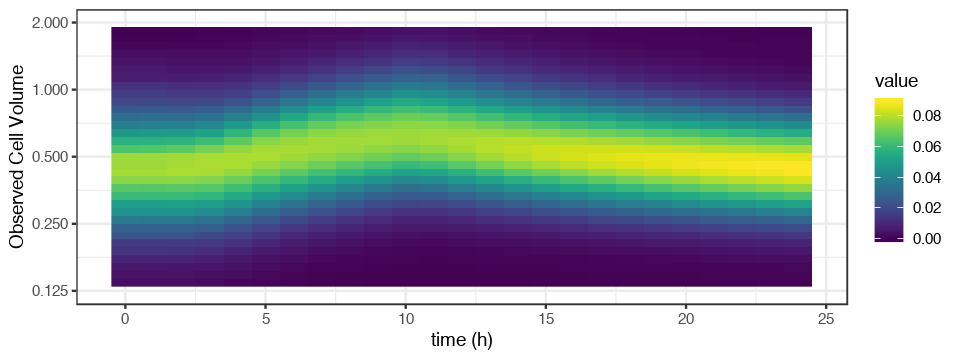

In [11]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

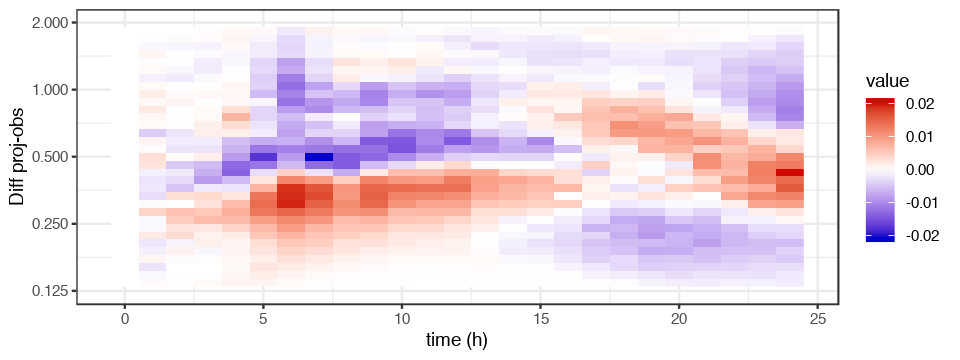

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

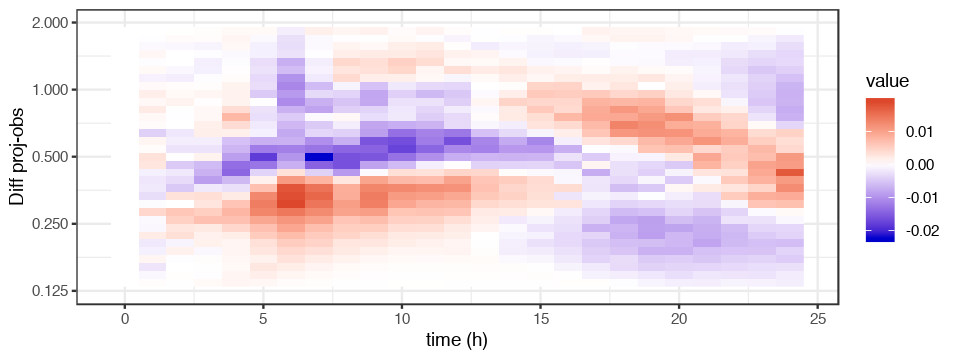

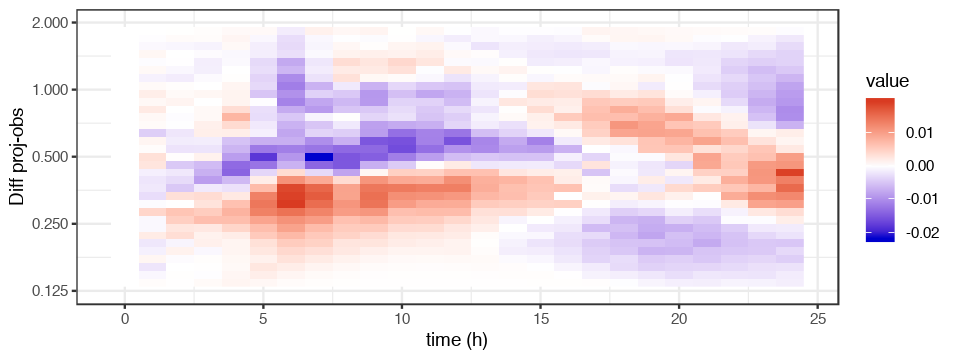

In [12]:
ggplot(melt(Vproj-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj.-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 2. Objective functions
---

- ### Differential evolution

In [13]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax.. <- as.numeric(params[1]) 
        dmax.. <- as.numeric(params[2]) / 10
        b.. <- as.numeric(params[3]) * 10
        E_star.. <- as.numeric(params[4]) * 1000
		resnorm.. <- opt$optim$bestval

Iteration: 10 bestvalit: 6.850031 bestmemit:    0.162886    0.355656    0.444295    0.180795
Iteration: 20 bestvalit: 6.740500 bestmemit:    0.155375    0.354050    0.402157    0.225668
Iteration: 30 bestvalit: 6.728994 bestmemit:    0.175302    0.327762    0.380647    0.254594
Iteration: 40 bestvalit: 6.717631 bestmemit:    0.175302    0.354325    0.393492    0.254594
Iteration: 50 bestvalit: 6.715933 bestmemit:    0.170793    0.342017    0.387260    0.253913
Iteration: 60 bestvalit: 6.715860 bestmemit:    0.170678    0.338914    0.385299    0.257187
Iteration: 70 bestvalit: 6.715630 bestmemit:    0.171408    0.344832    0.386507    0.253411
Iteration: 80 bestvalit: 6.715630 bestmemit:    0.171408    0.344832    0.386507    0.253411
Iteration: 90 bestvalit: 6.715491 bestmemit:    0.170816    0.344610    0.386395    0.254393
Iteration: 100 bestvalit: 6.715491 bestmemit:    0.170816    0.344610    0.386395    0.254393
Iteration: 110 bestvalit: 6.715455 bestmemit:    0.171277    0.344296

- ### Covariance matrix adapting evolutionary strategy

In [35]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt$par
        gmax... <- as.numeric(params[1]) 
        dmax... <- as.numeric(params[2]) / 10
        b... <- as.numeric(params[3]) * 10
        E_star... <- as.numeric(params[4]) * 1000
		resnorm... <- opt$value
print(params)

[1] 0.4118384 0.3115749 0.3958975 0.9835835


##  Results

In [28]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj.. <- Vproj... <-V.hists
Nproj.. <- Nproj... <- N.dist
mu_N.. <- mu_N... <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
        Nproj..[,hr+1] <- round(B %*% Nproj..[,hr]) # calculate numbers of individuals
	    Vproj..[,hr+1] <- B %*% Vproj..[,hr] # calculate the projected size-frequency distribution
		Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
		mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
					    ((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax..., dmax=dmax...,b=b..., E_star=E_star..., resol=resol)
      Nproj...[,hr+1] <- round(B. %*% Nproj...[,hr]) # calculate numbers of individuals
      Vproj...[,hr+1] <- B. %*% Vproj...[,hr] # calculate the projected size-frequency distribution
	    Vproj...[,hr+1] <- Vproj...[,hr+1]/sum(Vproj...[,hr+1]) # normalize distribution so sum = 1
		mu_N...[,hr+1] <- log(sum(Nproj...[,hr+1])/sum(Nproj...[,hr]))/
					    ((as.numeric(colnames(Nproj...)[hr+1])-as.numeric(colnames(Nproj...)[hr]))/(time.interval))				
    }

Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)
Nproj... <- colSums(Nproj...)
colnames(mu_N...) <- colnames(Vproj...)
#############################
## Growth rate calculation ##
#############################
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)
d.mu_N... <- 24*mean(mu_N...[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N..,2),"-",round(d.mu_N...,2)))

[1] "daily growth rate= 0.75 - 0.67"


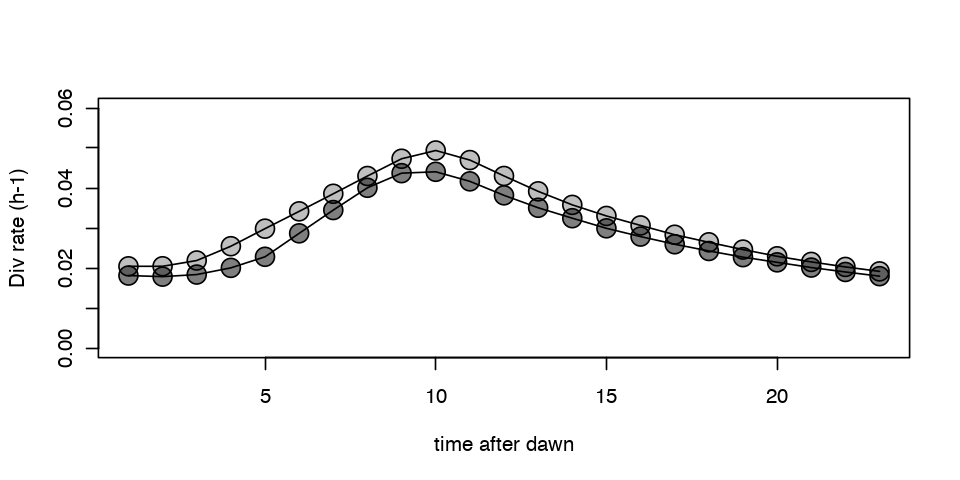

In [29]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N..[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N...[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

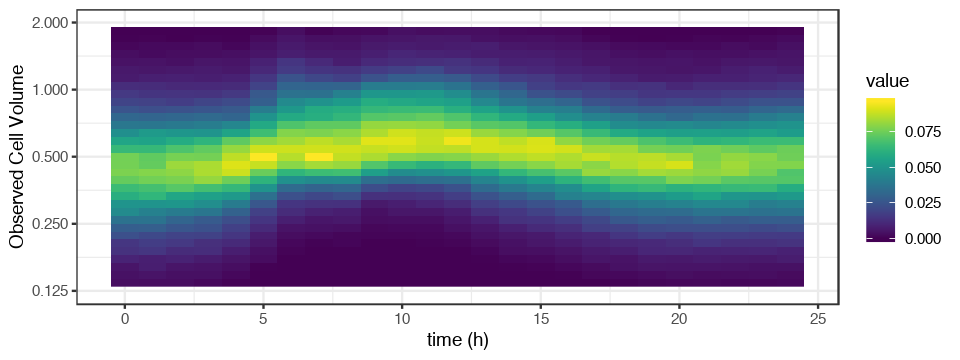

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

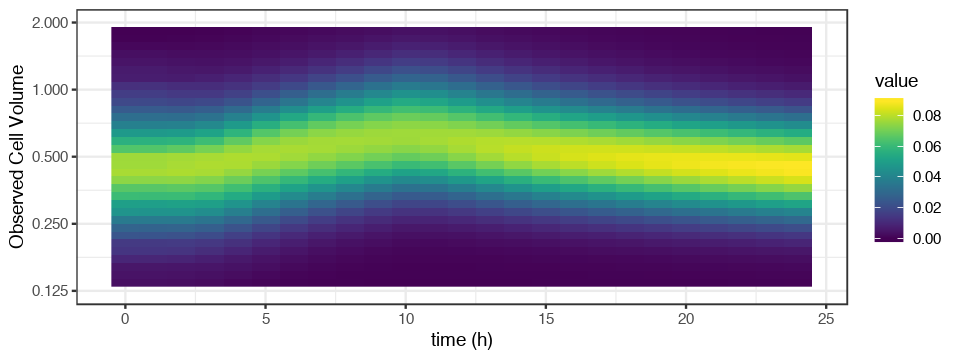

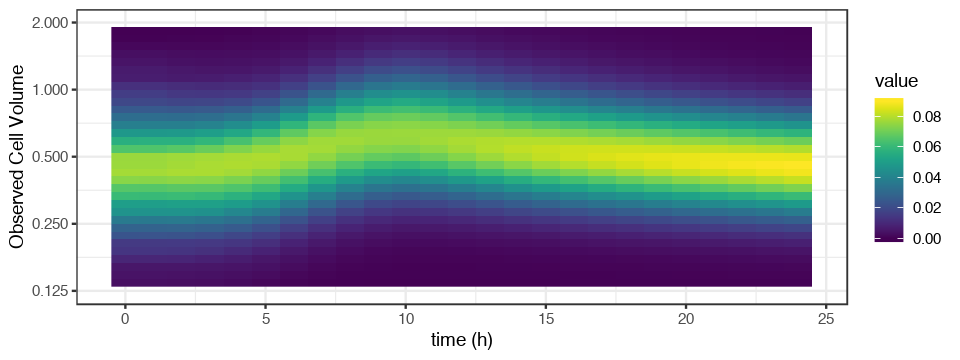

In [30]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj...), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

[1] 0.00222979


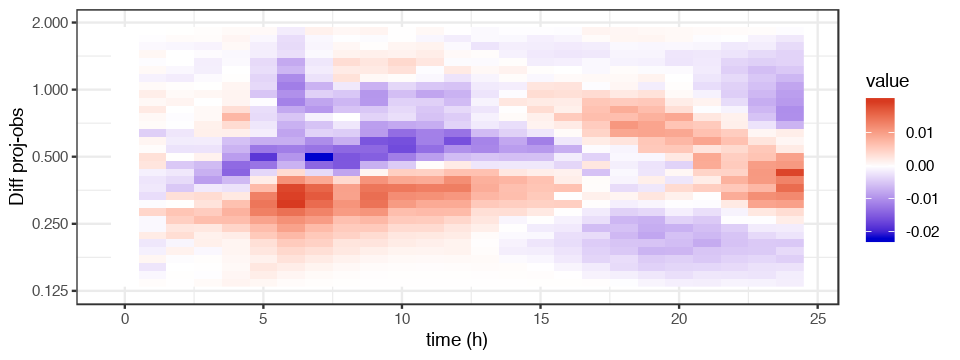

[1] 0.002431133


Warning message:
"Removed 600 rows containing missing values (geom_raster)."

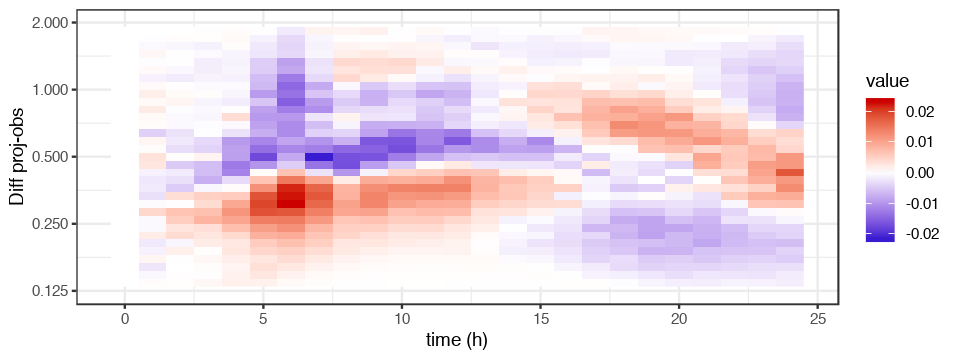

[1] 0.0005155002


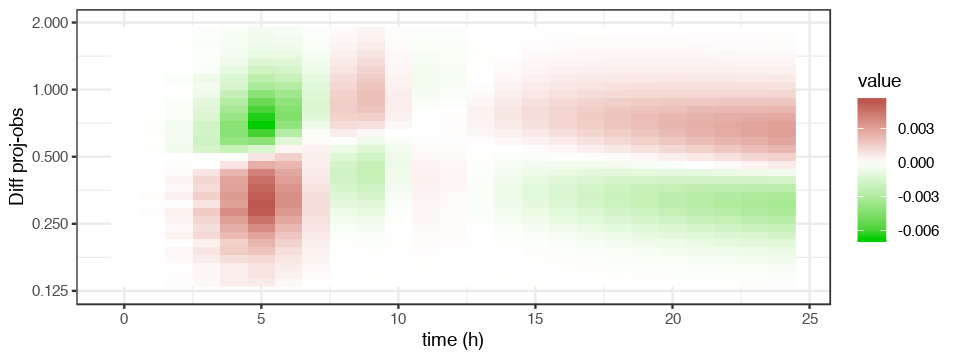

In [33]:
ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
print(mean(abs(Vproj..-V.hists)))

ggplot(melt(Vproj...-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
print(mean(abs(Vproj...-V.hists)))

ggplot(melt(Vproj...-Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='green3',high='brown', midpoint=0)
print(mean(abs(Vproj...-Vproj..)))